---
## Investigating patterns between Trump's tweets, current events, and his approval rating
---

After applying for and creating an API with Twitter, I was able to pull all of Donald Trump's tweets since the begininning of his presidency. The dataset I produced contains both retweets and original tweets. According to Twitter's API documentation, it also contains deleted Tweets. Using timeseries data as well as the contents of the tweets themselves, I will attempt to determine how current events relate to Donald Trumps's tweet rate, and similarly, how his approval rating relates to his Tweet rate.

---

## Reading In the Data

In [1]:
import pandas as pd
import numpy as np
import csv
import datetime
import matplotlib.pyplot as plt

pd.options.display.max_rows = 999
pd.set_option('max_colwidth', 999)

tweets =pd.read_csv('/Users/maxwalker/Desktop/EveryPresTweet.csv')


In [2]:
#Since the tweets were pulled in reverse chronoligical order, I will reindex the dataframe to put it in chronoligical order. I would expect the first Tweet to mark the beginning of his presidency. 
tweets = tweets[::-1]
tweets=tweets.reset_index().drop(columns='index')
tweets.head(10)

,text,created_at,id_str
0,It all begins today! I will see you at 11:00 A.M. for the swearing-in. THE MOVEMENT CONTINUES - THE WORK BEGINS!,01-20-2017 12:31:53,8.224214e+17
1,Today we are not merely transferring power from one Administration to another or from one party to another � but we are transferring...,01-20-2017 17:51:25,8.225018e+17
2,power from Washington D.C. and giving it back to you the American People. #InaugurationDay,01-20-2017 17:51:58,8.225019e+17
3,What truly matters is not which party controls our government but whether our government is controlled by the people.,01-20-2017 17:52:45,8.225021e+17
4,January 20th 2017 will be remembered as the day the people became the rulers of this nation again.,01-20-2017 17:53:17,8.225023e+17
5,The forgotten men and women of our country will be forgotten no longer. From this moment on it�s going to be #AmericaFirst????,01-20-2017 17:54:00,8.225025e+17
6,We will bring back our jobs. We will bring back our borders. We will bring back our wealth - and we will bring back our dreams!,01-20-2017 17:54:36,8.225026e+17
7,We will follow two simple rules: BUY AMERICAN &amp; HIRE AMERICAN!#InaugurationDay #MAGA????,01-20-2017 17:55:44,8.225029e+17
8,It is time to remember that...https://t.co/ZKyOiOor62,01-20-2017 17:58:24,8.225036e+17
9,So to all Americans in every city near and far small and large from mountain to mountain...https://t.co/cZKkrGXLSi,01-20-2017 18:00:43,8.225041e+17


In [3]:
tweets=tweets.drop(columns='id_str')
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16268 entries, 0 to 16267
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16267 non-null  object
 1   created_at  16268 non-null  object
dtypes: object(2)
memory usage: 254.3+ KB



It appears that each tweet is filling each row as intended but there are some immediate formatting issues that need to be resolved before I did deeper into the data. The first issue is that the '�' symbol is populating in places where apostrophes would be expected. After reviewing the tweets online I can confirm this is the case. We'll have to use string methods to replace these. Additionally, the '&' symbol is populating as '&amp;'. I will handle these the same way. There is one row with a null value in the text column. I will remove this row. Lastly, I will change the column names to something more fitting while also changing the date column to a datetime object.

---

## Cleaning the Data

In [4]:
tweets.columns= ['text', 'time']
bad_row = tweets[tweets.isnull().any(axis=1)]
print(bad_row)
print('\n')

tweets = tweets.drop(index=3066).reset_index().drop(columns='index')
print(tweets.isnull().sum())

     text                 time
3066  NaN  05-24-2018 17:54:36


text    0
time    0
dtype: int64


In [5]:
tweets['text'] = tweets['text'].str.replace('�', '\'')
tweets['text'] = tweets['text'].str.replace('&amp;', '& ')


In [6]:
tweets['time'] = pd.to_datetime(tweets['time'])

With over 16,000 tweets I cant just look at the oldest or most recent values to ensure that the data is formatted correctly. Lets take a sample to ensure that there are no dramatic issues with our data.


In [7]:
sample = tweets.sample(frac=.0005, random_state=1)
sample

,text,time
6982,We will never forget our fallen HEROES. It was our great honor to be with you today! #FlagsIn https://t.co/Z6OvQUr8lT,2019-05-23 23:34:53
2762,A perfectly executed strike last night. Thank you to France and the United Kingdom for their wisdom and the power of their fine Military. Could not have had a better result. Mission Accomplished!,2018-04-14 12:21:00
8421,RT @GOPChairwoman: Thanks to the unhinged mob on the left @realDonaldTrump raised $12M today $2M more than originally expected.The supp',2019-08-09 20:36:30
12257,....Joe Biden and Bernie is shut out again. Very unfair but that's the way the Democrats play the game. Anyway it's a lot of fun to watch!,2020-01-17 15:35:04
14748,RT @DonaldJTrumpJr: Great to hear! CA's Gov Newsom about @realDonaldTrump'Let me just be candid with you. I'd be lying to you to say that',2020-04-02 13:26:50
9414,"RT @MZHemingway: Guess who caught the New York Times' Kavanaugh authors in another huge error? This time in the Atlantic. ""Witnesses Defend'",2019-09-18 11:38:11
5679,Heading now to the Great State of Alabama!,2019-03-08 14:59:22
12197,RT @kilmeade: .@jockowillink says President @realDonaldTrump's gamble ordering the strike that killed Soleimani was a brilliant move that k',2020-01-15 05:54:27


After inspecting a random sample, I feel confident that all tweet text is populating correctly. I will now turn my attention towards the time column to ensure all tweets are in the correct chronological order.


In [8]:
tweets_copy = tweets.sort_values(['time'])
tweets_copy


,text,time
0,It all begins today! I will see you at 11:00 A.M. for the swearing-in. THE MOVEMENT CONTINUES - THE WORK BEGINS!,2017-01-20 12:31:53
1,Today we are not merely transferring power from one Administration to another or from one party to another ' but we are transferring...,2017-01-20 17:51:25
2,power from Washington D.C. and giving it back to you the American People. #InaugurationDay,2017-01-20 17:51:58
3,What truly matters is not which party controls our government but whether our government is controlled by the people.,2017-01-20 17:52:45
4,January 20th 2017 will be remembered as the day the people became the rulers of this nation again.,2017-01-20 17:53:17
...,...,...
16262,They professionally managed so-called 'protesters' at the White House had little to do with the memory of George Floyd. They were just there to cause trouble. The @SecretService handled them easily. Tonight I understand is MAGA NIGHT AT THE WHITE HOUSE???,2020-05-30 13:27:47
16263,The professionally managed so-called 'protesters' at the White House had little to do with the memory of George Floyd. They were just there to cause trouble. The @SecretService handled them easily. Tonight I understand is MAGA NIGHT AT THE WHITE HOUSE???,2020-05-30 13:34:02
16264,These are 'Organized Groups' that have nothing to do with George Floyd. Sad!,2020-05-30 14:00:49
16265,Mayor Jacob Frey of Minneapolis will never be mistaken for the late great General Douglas McArthur or great fighter General George Patton. How come all of these places that defend so poorly are run by Liberal Democrats? Get tough and fight (and arrest the bad ones). STRENGTH!,2020-05-30 14:25:02


While it would be impractical to verify the time for each of the 16,267 tweets, I am able to see that the first and last five tweets in the tweets dataframe are in their correct positions respectively when the data frame is sorted on the time column. From this we can be sure that there are no outliers with respect to the datetime data and that each tweet collected falls within the bounds of the inaugration and the day this data was obtained (5/30/2020). 

---

## New time columns

To make the time data more approachable I will add seperate column noting how many weeks and months had passed since inaugeration when the tweet was sent. We would expect tweets from the first week and month values to be 0  and the last few to have a number between 150 and 200 for the weeks and around 40 for the months . 

In [9]:
def week(time):
    day1= datetime.date(2017,1,20)
    date_of_tweet = time.date()
    week_diff= round((date_of_tweet - day1).days / 7)
    return week_diff

def month(time):
    day1= datetime.date(2017,1,20)
    date_of_tweet = time.date()
    month_diff= round((date_of_tweet - day1).days / 30)
    return month_diff


tweets['week'] = tweets['time'].apply(lambda x: week(x))
tweets['month'] = tweets['time'].apply(lambda x: month(x))
tweets

,text,time,week,month
0,It all begins today! I will see you at 11:00 A.M. for the swearing-in. THE MOVEMENT CONTINUES - THE WORK BEGINS!,2017-01-20 12:31:53,0,0
1,Today we are not merely transferring power from one Administration to another or from one party to another ' but we are transferring...,2017-01-20 17:51:25,0,0
2,power from Washington D.C. and giving it back to you the American People. #InaugurationDay,2017-01-20 17:51:58,0,0
3,What truly matters is not which party controls our government but whether our government is controlled by the people.,2017-01-20 17:52:45,0,0
4,January 20th 2017 will be remembered as the day the people became the rulers of this nation again.,2017-01-20 17:53:17,0,0
...,...,...,...,...
16262,They professionally managed so-called 'protesters' at the White House had little to do with the memory of George Floyd. They were just there to cause trouble. The @SecretService handled them easily. Tonight I understand is MAGA NIGHT AT THE WHITE HOUSE???,2020-05-30 13:27:47,175,41
16263,The professionally managed so-called 'protesters' at the White House had little to do with the memory of George Floyd. They were just there to cause trouble. The @SecretService handled them easily. Tonight I understand is MAGA NIGHT AT THE WHITE HOUSE???,2020-05-30 13:34:02,175,41
16264,These are 'Organized Groups' that have nothing to do with George Floyd. Sad!,2020-05-30 14:00:49,175,41
16265,Mayor Jacob Frey of Minneapolis will never be mistaken for the late great General Douglas McArthur or great fighter General George Patton. How come all of these places that defend so poorly are run by Liberal Democrats? Get tough and fight (and arrest the bad ones). STRENGTH!,2020-05-30 14:25:02,175,41


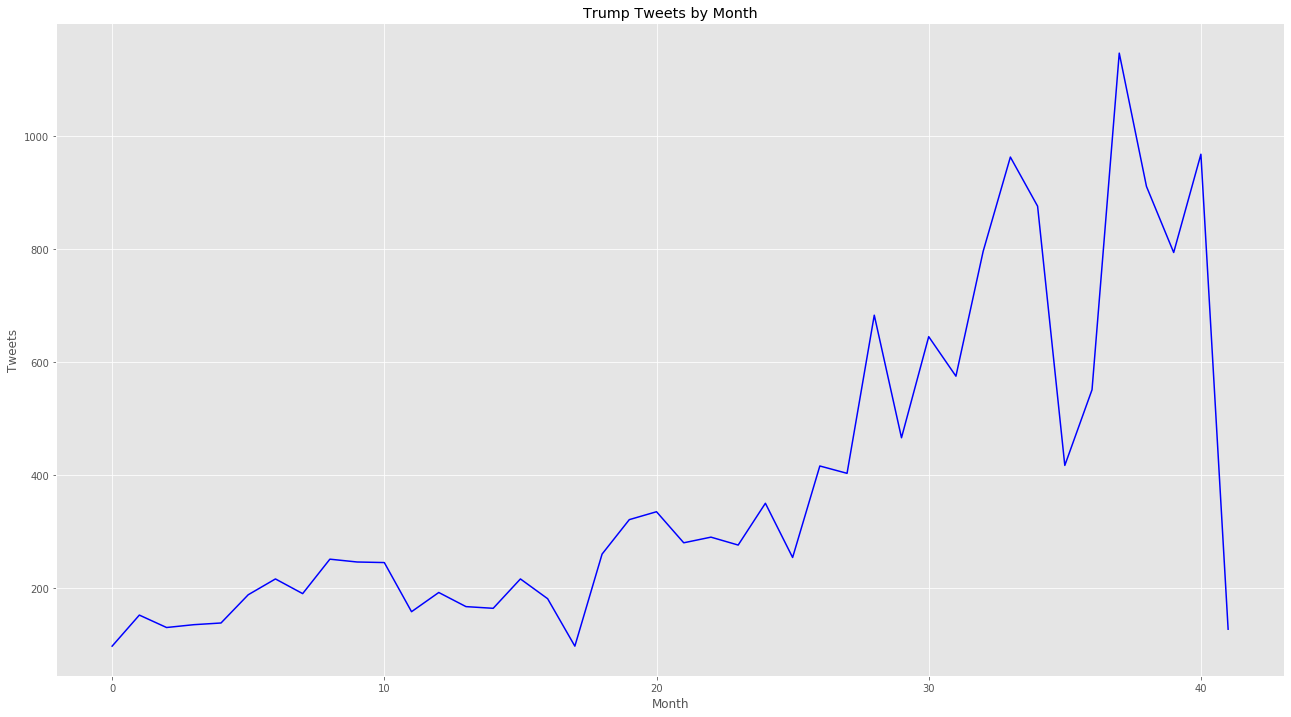

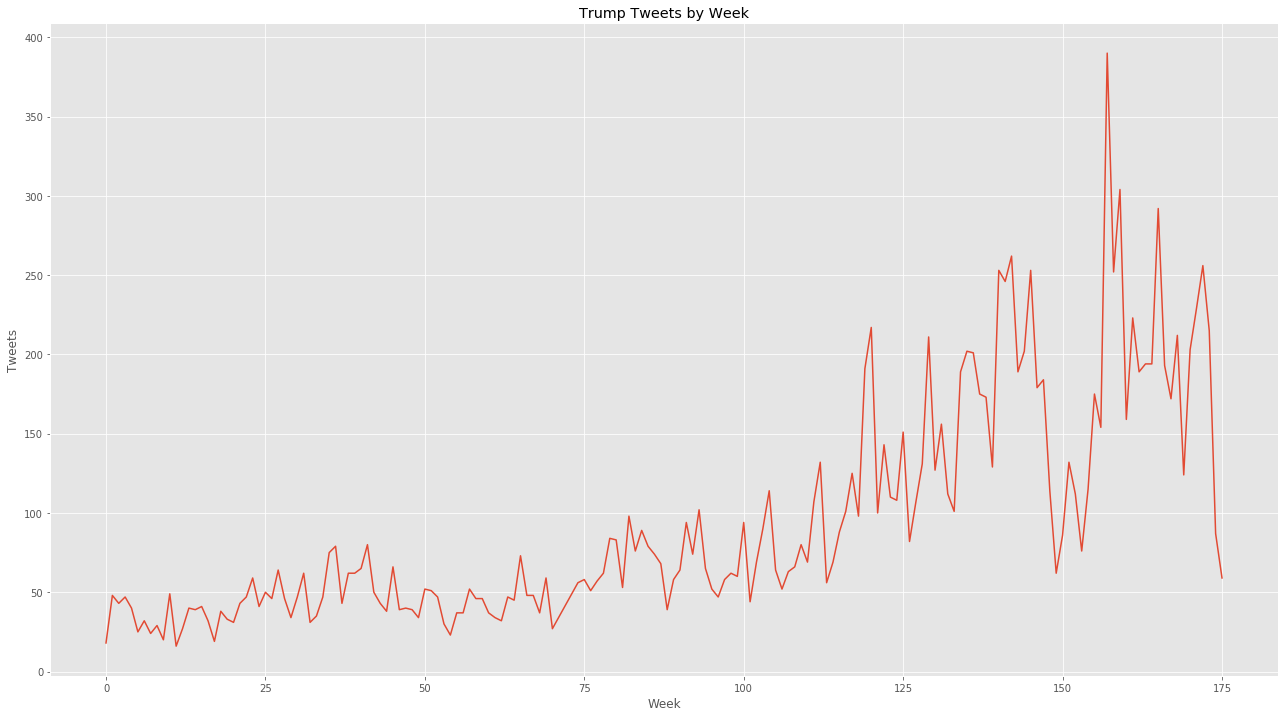

In [10]:
week_counts = tweets['week'].value_counts().sort_index()
month_counts = tweets['month'].value_counts().sort_index()
fig = plt.figure(figsize=(22,12))
plt.style.use('ggplot')
plt.plot(month_counts, color='blue')
plt.xlabel('Month')
plt.ylabel('Tweets')
plt.title('Trump Tweets by Month')
plt.show()

fig = plt.figure(figsize=(22,12))
plt.style.use('ggplot')
plt.plot(week_counts)
plt.xlabel('Week')
plt.ylabel('Tweets')
plt.title('Trump Tweets by Week')
plt.show()



Through the monthly data, it is clear the Donald Trump is Tweeting far more often while also tweeting more sporadically. While the monthly data helps identify longterm trends, it struggles to identify a few of the key outliers that make the weekly data so interesting and may be too long of a timeframe to identify specific current events that would lead to spikes and dips. The weekly data will be our focus moving forward. 


For the first two years of his presidency Trump generally tweeted between 25 and 100 tiems per week. However after the two year mark he began Tweeting around 150-250 Tweets per week with a few dramatic spikes topping three hundred Tweets per week. 



- The first outlier occurs around the the 120 week mark when Trump tweets roughly 220 times after having never tweeted over 150 time in a given week prior. 

- The second outlier occurs around the 130 week mark as Trump's tweets over 200 times in a week for only the 2nd time in his presidency. 

- The third outlier occurs around the 149 week mark as Trump's tweets plummet to less than 75 times per week after having been above 250 a few weeks prior. 

- The fourth outlier occurs just weeks later as Trump tweeted a personal high, nearly 400 times in a week. 

- The fifth outlier occurs only a week prior to this writing as Trump tweets under 100 times in a week for the first time in months.

I'll investigate what may have caused each of these outliers. As I uncover the causes of each spike and dip, hopefully a pattern will emerge shedding light on what types of events caused the spikes or dips. Specifically, I am interested in seeing whether there is a pattern between positive and negative current events and Trump's rate of tweeting. To represent this I will mark each spike or dip with a vertical line: red for negative events, green for positive events, and black for neutral events. Because I haven't determined what each event is yet, I'll mark each as black for now. 

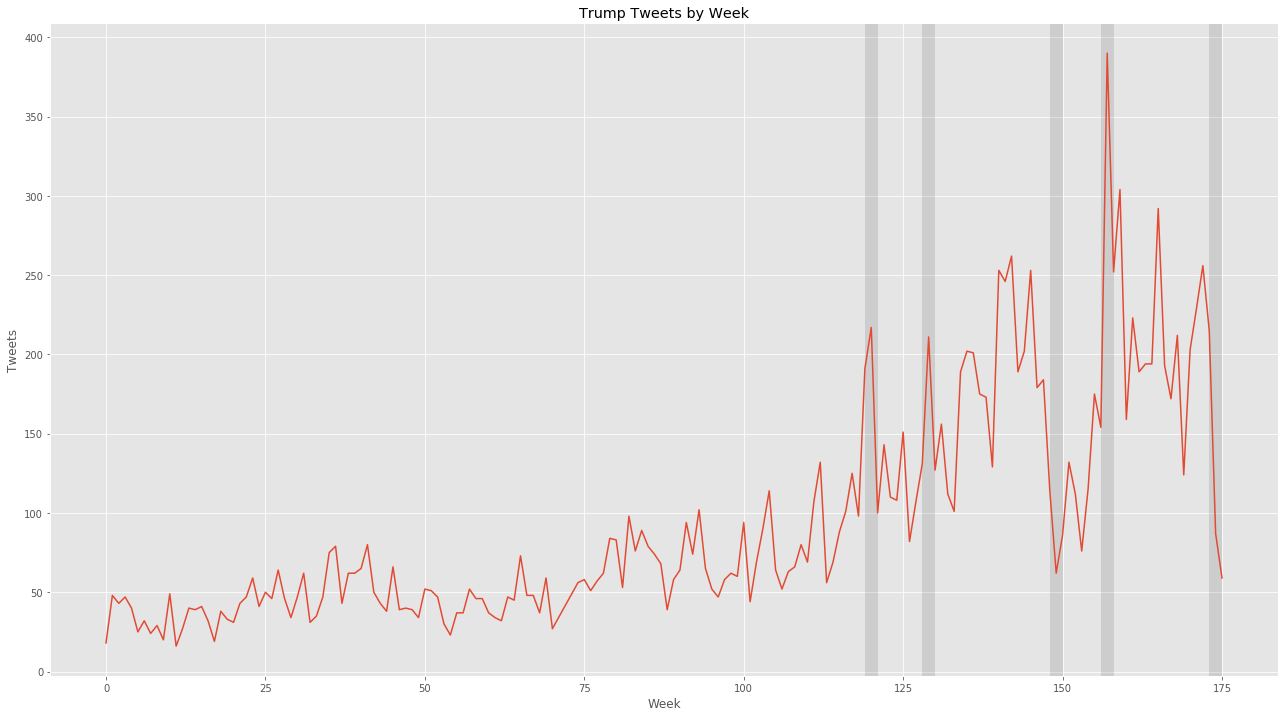

In [11]:
fig = plt.figure(figsize=(22,12))
plt.style.use('ggplot')
plt.plot(week_counts)
plt.xlabel('Week')
plt.ylabel('Tweets')
plt.title('Trump Tweets by Week')
plt.axvspan(119, 121, facecolor='black', alpha=0.1)
plt.axvspan(128, 130, facecolor='black', alpha=0.1)
plt.axvspan(148, 150, facecolor='black', alpha=0.1)
plt.axvspan(156, 158, facecolor='black', alpha=0.1)
plt.axvspan(173, 175, facecolor='black', alpha=0.1)


---
## Outlier #1

Trump's first spike in Tweets occurred around the 120 week mark. Lets pull these tweets to see what spurred such a dramatic increase.


In [12]:
week_120 = tweets[tweets['week']==120]
print('Tweets in week 120: ' + str(len(week_120)))
week_120.sample(frac=.04, random_state=1)

Tweets in week 120: 217


,text,time,week,month
6679,Your all time favorite President got tired of waiting for China to help out and start buying from our FARMERS the greatest anywhere in the World!,2019-05-10 12:55:27,120,28
6634,Republicans shouldn't vote for H.R. 312 a special interest casino Bill backed by Elizabeth (Pocahontas) Warren. It is unfair and doesn't treat Native Americans equally!,2019-05-08 15:48:06,120,28
6635,Our Nation grieves at the unspeakable violence that took a precious young life and badly injured others in Colorado. God be with the families and thank you to the First Responders for bravely intervening. We are in close contact with Law Enforcement.,2019-05-08 17:42:44,120,28
6663,Tariffs will bring in FAR MORE wealth to our Country than even a phenomenal deal of the traditional kind. Also much easier & quicker to do. Our Farmers will do better faster and starving nations can now be helped. Waivers on some products will be granted or go to new source!,2019-05-10 11:22:21,120,28
6698,"RT @TomFitton: FBI Official: Barack Obama's White House Was A ""Repository"" For Hillary Clinton's Emails - @JudicialWatch https://t.co/8bONh'",2019-05-11 11:59:05,120,28
6696,RT @hughhewitt: The Mueller probe has concluded after vast effort that there was no collusion. Senate Intel subpoena to @DonaldJTrumpJr s',2019-05-11 11:57:54,120,28
6719,RT @TomFitton: .@SenatorBurr harasses @DonaldJTrumpJr with another subpoena while excusing unprecedented corruption targeting @realDonaldTr',2019-05-11 12:10:25,120,28
6795,..There will be nobody left in China to do business with. Very bad for China very good for USA! But China has taken so advantage of the U.S. for so many years that they are way ahead (Our Presidents did not do the job). Therefore China should not retaliate-will only get worse!,2019-05-13 10:40:25,120,28
6685,....into the future will continue. In the meantime the United States has imposed Tariffs on China which may or may not be removed depending on what happens with respect to future negotiations!,2019-05-10 19:14:04,120,28


This dramatic increase in tweets came in early May, 2019. The increase in Tweets appears to relate to trade negotiations with China. This event is not overwhemingly negative or positive from Trump's perspective so I'll keep it as a black line. 

---
## Outlier #2

Less than two months later Trump's tweets again spiked to over 200 in a week.


In [13]:
week_129 = tweets[tweets['week']==129]
print('Tweets in week 129: ' + str(len(week_129)))
week_129.sample(frac=.04, random_state=1)

Tweets in week 129: 211


,text,time,week,month
7794,...or a very nervous and skinny version of Pocahontas (1000/24th) as your President rather than what you have now so great looking and smart a true Stable Genius! Sorry to say that even Social Media would be driven out of business along with and finally the Fake News Media!,2019-07-11 11:30:02,129,30
7939,Friday's tour showed vividly to politicians and the media how well run and clean the children's detention centers are. Great reviews! Failing @nytimes story was FAKE! The adult single men areas were clean but crowded - also loaded up with a big percentage of criminals......,2019-07-14 13:45:45,129,30
7801,Robert Johnson B.E.T. 'I give the President a lot of credit for moving the Economy in a positive direction that's benefiting a large number of Americans. I think the Tax Cuts clearly helped stimulate the Economy. Overall if you look at the U.S. Economy and you look at.....,2019-07-11 11:42:01,129,30
7949,If Democrats want to unite around the foul language & racist hatred spewed from the mouths and actions of these very unpopular & unrepresentative Congresswomen it will be interesting to see how it plays out. I can tell you that they have made Israel feel abandoned by the U.S.,2019-07-15 11:42:25,129,30
7785,Today on this 'USMCA Day of Action' thousands of grassroots supporters are urging Congress to pass the great bipartisan USMCA. USMCA = more JOBS for American workers more economic growth and more OPPORTUNITY for our farmers ranchers and businesses. #USMCAnow https://t.co/sYMhKSDu5w,2019-07-10 23:38:33,129,30
7839,RT @realDonaldTrump: #SocialMediaSummit @WhiteHouse https://t.co/Z7tlvC3QUN,2019-07-12 11:31:01,129,30
7783,My Administration is taking groundbreaking action to bring new hope to millions of Americans suffering from kidney disease. Today I signed an Executive Order Advancing American Kidney Health...https://t.co/tAlFdDSTUU,2019-07-10 16:59:55,129,30
7900,RT @JudicialWatch: @TomFitton: Why Didn't Mueller Investigate Clinton Campaign Getting Anti-Trump Dirt from Russians? https://t.co/bHMktH5F',2019-07-13 12:12:21,129,30


There doesn't appear to be one event that stands out from the tweets. After viewing a timeline of Trumps presidency at https://en.wikipedia.org/wiki/Timeline_of_the_Donald_Trump_presidency_(2019_Q3)#Week_129, I can confirm that no noteworthy events occured this week. Again, we'll leave this line black.

---
## Outlier #3
Trump's tweet rate rose steadily until week 149 when to below 100 for two of the next three weeks after having been consistently above 200 two weeks prior. Lets look at these weeks to see what could have been going on that would discourage Trump from Tweeting.

In [14]:
three_week_dip = tweets[(tweets['week']>147) & (tweets['week']<152)]
three_week_dip.sample(frac=.02, random_state=1)

,text,time,week,month
11375,....ANY DIRECT EVIDENCE THAT PRESIDENT TRUMP DID ANYTHING IMPEACHABLE. No one heard him order a quid pro quo. No one offered a convincing reason why Trump's interest in having Ukraine probe potential cortuption warrants Impeachment. 'I want no Quid Pro Quo' Ambassador....,2019-11-23 19:52:58,148,35
11519,Our Economy is the envy of the World!,2019-12-07 18:55:17,150,35
11647,It was my Great Honor to attend the 120th Army-Navy game today in Philadelphia Pennsylvania! @NavyFB @ArmyWP_Football @ArmyNavyGame https://t.co/HipWiZKmiP,2019-12-15 01:02:27,151,35
11413,When the Military rips down an old & badly broken Border Wall in an important location & replaces it with a brand new 30 ft. high Steel & Concrete Wall Nancy Pelosi says we are not building a Wall. Wrong and it is going up fast. Brandon Judd just gave us great marks! @FoxNews,2019-11-26 11:53:16,149,35
11502,Just received a full briefing on the tragic shooting at NAS Pensacola in Florida and spoke to @GovRonDeSantis. My thoughts and prayers are with the victims and their families during this difficult time. We are continuing to monitor the situation as the investigation is ongoing.,2019-12-06 18:16:21,150,35
11491,Republican Approval Rating = 95%. Thank you!,2019-12-05 17:38:03,150,35
11372,.....Brennan too. And the Whistleblower also worked for Susan Rice. It's an understatement to say that this is a Witch Hunt.' @IngrahamAngle They spied on my campaign!,2019-11-23 17:05:49,148,35
11386,Polls have now turned very strongly against Impeachment especially in swing states. 75% to 25%. Thank you!,2019-11-24 12:34:33,148,35


During  November and December of 2020 the Impeachment hearings standout out as  the most meaninful event. Interestingly, this overwheminly negative event from Trump's perspective coincided with the most dramatic decrease in Tweets up to this point of his presidency. I'll mark this timeframe as red on the graph to symobolize it as an unfavorable time from Trump's perspective. It will be intersting to see if the next dramatic decrease in Tweets also occurs during an unfavorable time for Trump. 

---
## Outlier # 4
This dramatic dip was followed by a dramatic spike one month later. Lets look at these dates

In [15]:
week_157 = tweets[tweets['week']==157]
print('Tweets in week 157: ' + str(len(week_157)))
week_157.sample(frac=.02, random_state=1)

Tweets in week 157: 390


,text,time,week,month
12413,RT @marklevinshow: More on my opening https://t.co/nnp5r2hhU5,2020-01-22 13:41:26,157,37
12500,https://t.co/Acyh0HStm8,2020-01-24 02:40:03,157,37
12447,RT @DonaldJTrumpJr: .@realDonaldTrump makes a very solid point here. Hillary talking about other people's like-ability is peak 2020. https:',2020-01-22 19:54:06,157,37
12382,ENJOY! https://t.co/xqEoCLJy0Y,2020-01-22 09:34:38,157,37
12548,Jim is great! https://t.co/SxjDSlaP7J,2020-01-24 15:11:25,157,37
12651,"RT @SenateGOP: ???? ""Groundhog Day in the Senate"" feat. @RepAdamSchiff https://t.co/hkk41XezQY",2020-01-26 04:13:37,157,37
12564,RT @realDonaldTrump: The Do Nothing Democrats just keep repeating and repeating over and over again the same old 'stuff' on the Impeachme',2020-01-25 01:41:07,157,37
12580,"RT @HouseGOP: ""The American people see this for what it is which is a disingenuous attack on the President. The Democrats keep saying 'Ou'",2020-01-25 03:22:13,157,37


While not immediately clear from the contents of this sample, a glance at a timeline of Trump's presidency https://en.wikipedia.org/wiki/Timeline_of_the_Donald_Trump_presidency_(2020_Q1) shows that he the Senate votes 53–47 to approve the rules of President Trump's impeachment trial, blocking the inclusion of new evidence or witness testimony. This is a huge blow to the chances of impachment and is unquestionably favorable news from Trump's perspective. I will mark this in green.


---

## Outlier #5 
The final dramatic shift in Trump's tweet rate can be seen at week 174 as weekly tweets plummet to a level not seen since the impeachment inquiries. I will include week 175 in this because it is still a partial week at the time this data was collected. Lets look at these weeks.

In [16]:
final_dip = tweets[(tweets['week']==174) | (tweets['week']==175)]
final_dip.sample(frac=.05, random_state=1)

,text,time,week,month
16219,@USAttyHuber Whatever happen to John Huber?,2020-05-28 12:09:21,175,41
16187,The Wacky Do Nothing Attorney General of Michigan Dana Nessel is viciously threatening Ford Motor Company for the fact that I inspected a Ventilator plant without a mask. Not their fault & I did put on a mask. No wonder many auto companies left Michigan until I came along!,2020-05-22 03:14:05,174,41
16174,https://t.co/pAC6D3uhDA,2020-05-21 22:26:40,174,41
16196,$49.8M is on its way to @DallasLoveField Airport to aid in economic recovery. This Federal funding will support aviation in the Dallas area & keep aviation workers on the job & commerce moving at one of our important medium hub airports. Proud to support our friends in Dallas!,2020-05-22 22:31:04,174,41
16242,.@Facebook CEO Mark Zuckerberg is today criticizing Twitter. 'We have a different policy than Twitter on this. I believe strongly that Facebook shouldn't be the arbiter of truth of everything that people say online.' Did Twitter criticize Obama for his 'you can keep your Dr.'?,2020-05-29 00:48:59,175,41
16195,I am proud to announce that the Maryland Aviation Administration (@MdAviation) will receive $87.8M in CARES Act Airport Grants funding to support aviation and keep commerce moving at this important gateway to the U.S. Capital Region. Very important for economic recovery!,2020-05-22 22:29:43,174,41
16240,https://t.co/mFzyzW74uY,2020-05-29 00:06:32,175,41


Trump's unsually quiet week came at the intersection of two major events, each of which were negative from Trump's perspecitive. First, the U.S eclipsed 100,000 covid-19 deaths. Second, Twitter decided to begin fact-checking Trump's tweets, a stance that Trump adamently opposes. Similar to the first dip, this dip coincided with unfavorable events from Trump's perspective so it will also be marked in red. 

---

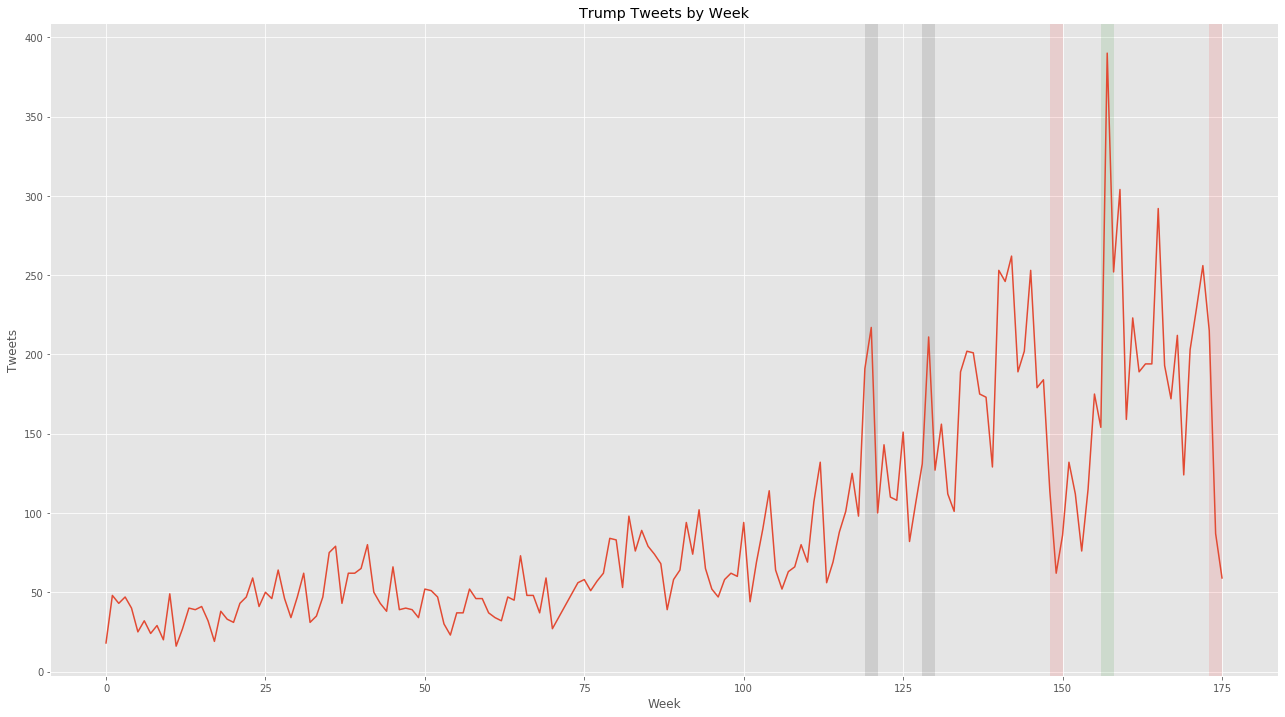

In [17]:
fig = plt.figure(figsize=(22,12))
plt.style.use('ggplot')
plt.plot(week_counts)
plt.xlabel('Week')
plt.ylabel('Tweets')
plt.title('Trump Tweets by Week')
plt.axvspan(119, 121, facecolor='black', alpha=0.1)
plt.axvspan(128, 130, facecolor='black', alpha=0.1)
plt.axvspan(148, 150, facecolor='red', alpha=0.1)
plt.axvspan(156, 158, facecolor='green', alpha=0.1)
plt.axvspan(173, 175, facecolor='red', alpha=0.1)

---
## Analysis and Paterns

By understanding when Donald Trump Tweeted and when he didn't, I was able to match these spikes and dips with current events to gain a better understanding of what motivates him to Tweet. It appears that Trump chooses to Tweet more during favorable (or atleast neutral) times while each dramatic dip corresponded with a particularly negative time for Trump. 

---
Next I will use data on Trump's approval rating to see whether it supports or contradicts these trends. (Source: https://projects.fivethirtyeight.com/trump-approval-data/approval_topline.csv )

In [18]:
approval =pd.read_csv('/Users/maxwalker/Desktop/approval_rating.csv')

In [19]:
print(approval.info())
approval

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   modeldate            3672 non-null   object 
 1   approve_estimate     3672 non-null   float64
 2   disapprove_estimate  3672 non-null   float64
 3   timestamp            3672 non-null   object 
dtypes: float64(2), object(2)
memory usage: 114.9+ KB
None


,modeldate,approve_estimate,disapprove_estimate,timestamp
0,5/30/20,42.551211,53.377343,5/31/20 0:20
1,5/30/20,42.908880,53.676659,5/31/20 0:23
2,5/30/20,42.648350,53.572363,5/31/20 0:18
3,5/29/20,42.551211,53.377343,5/29/20 15:35
4,5/29/20,42.908880,53.676659,5/29/20 15:37
...,...,...,...,...
3667,1/24/17,45.000000,45.746590,3/2/17 11:26
3668,1/24/17,45.442640,41.878490,3/2/17 11:25
3669,1/23/17,45.466930,41.264520,3/2/17 11:25
3670,1/23/17,46.000000,37.000000,3/2/17 11:26


First I'll flip the data so it matches the same chronological order as the Tweet data. Then I will drop the 'timestamp' column because the 'modeldate' column offers the same information. Afterwards I will use the week function in a similar manner as I did the Tweet data and group the data as weeks as opposed to individual surveys. Finally, I will plot the results in conjunction with the Tweet data to see if any trends stand out. While I don't expect the approval rating data to mirror the dramatic increase in Tweets over the second half of Trump's presidency, I do expect the largest spikes and dips to correspond with increases and decreases in Trump's approval rating. 




In [20]:
approval = approval.loc[::-1]

In [21]:
approval = approval.drop(columns='timestamp')
approval['modeldate']=pd.to_datetime(approval['modeldate'])

In [22]:

approval['week'] = approval['modeldate'].apply(lambda x: week(x))
approval['month'] = approval['modeldate'].apply(lambda x: month(x))



In [23]:

approval = approval.groupby('week')['approve_estimate'].mean()
print(approval.head())



week
0    45.488977
1    44.553543
2    44.584772
3    44.248437
4    43.925046
Name: approve_estimate, dtype: float64


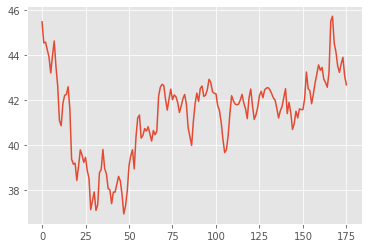

In [24]:
plt.plot(approval)

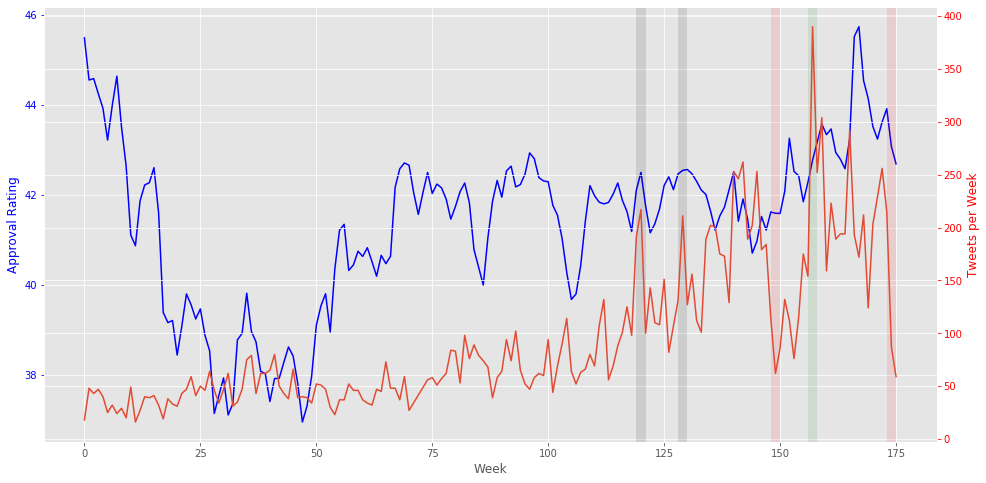

In [25]:
plt.rc('figure', figsize=(16, 8))
fig, ax1 = plt.subplots()
plt.style.use('ggplot')
ax1.plot(approval, color='blue')
ax1.set_label('Approval Rating')
ax1.set_xlabel('Week')
ax1.set_ylabel('Approval Rating')
ax1.yaxis.label.set_color('blue')
ax1.tick_params(axis='y', colors='blue')


ax2 = ax1.twinx()
ax2.plot(week_counts)
ax2.axvspan(119, 121, facecolor='black', alpha=0.1)
ax2.axvspan(128, 130, facecolor='black', alpha=0.1)
ax2.axvspan(148, 150, facecolor='red', alpha=0.1)
ax2.axvspan(156, 158, facecolor='green', alpha=0.1)
ax2.axvspan(173, 175, facecolor='red', alpha=0.1)
ax2.set_ylabel('Tweets per Week')
ax2.yaxis.label.set_color('red')
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')



Since the graph is a bit crowded and since I didn't find any large spikes or dips over the first half of Trump's presidency, I will look only at the final 70 weeks to see if the patterns become clearer.

In [26]:
approval_end = approval[approval.index>104]
tweets_end = week_counts[week_counts.index>104]

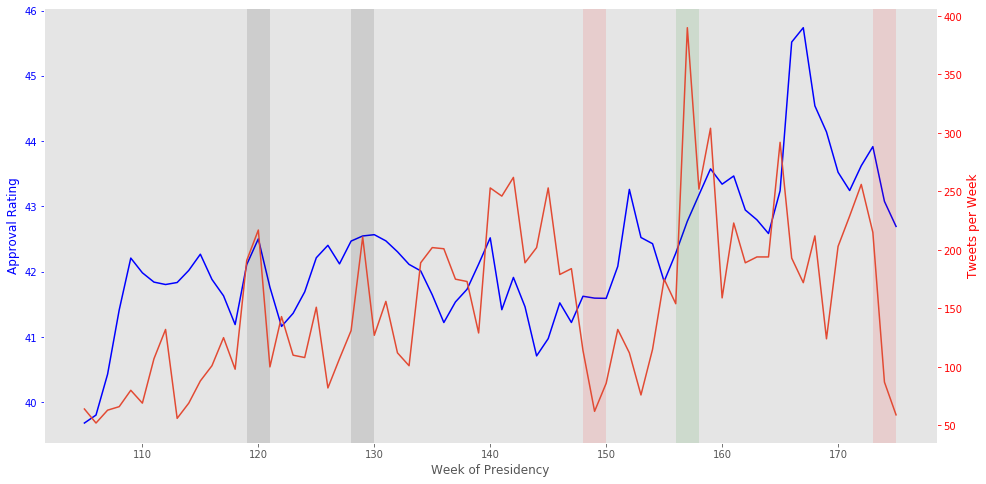

In [27]:
plt.rc('figure', figsize=(16, 8))
fig, ax1 = plt.subplots()
plt.style.use('ggplot', )
ax1.plot(approval_end, color='blue')
ax1.set_label('Approval Rating')
ax1.set_xlabel('Week of Presidency')
ax1.set_ylabel('Approval Rating')
ax1.yaxis.label.set_color('blue')
ax1.tick_params(axis='y', colors='blue')
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(tweets_end)
ax2.axvspan(119, 121, facecolor='black', alpha=0.1)
ax2.axvspan(128, 130, facecolor='black', alpha=0.1)
ax2.axvspan(148, 150, facecolor='red', alpha=0.1)
ax2.axvspan(156, 158, facecolor='green', alpha=0.1)
ax2.axvspan(173, 175, facecolor='red', alpha=0.1)
ax2.set_ylabel('Tweets per Week')
ax2.yaxis.label.set_color('red')
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')
ax2.grid(False)


Here I can see that there does appear to be a pattern between Trump's tweet count and approval rating, especially with regards to the dramatic spikes and dips described earlier.

- When looking at the first two spikes in Tweets (weeks 120 and 128), they perfectly align with the local maximum's with regard to Trump's approval ratings. 
- The first dip in Tweets occured at a time when Trump's approval rating, while stagnant, was lower than average (week 148).
- When Trump's Tweets more that at any other time during his presidency (week 157), his approval rating spikes up as well. 
- Most interestingly, the last few weeks of Trump's approval rating and tweet counts mirror eachother nearly exactly, with a sharp increase roughly four weeks ago and sharp decreases thereafter. 

While causation cannot be immediately determined, it appears that Trump is Tweeting more during neutral or favorable time periods, when his approval rating is spiking. Similarly, his Tweet rate decreases during unfavorable times, when his approval rating is dipping.